# Neural newtorks (Veštačke neuronske mreže)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from sklearn.preprocessing import MinMaxScaler

In [53]:
df = pd.read_csv('../london_weather.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


## Opis karakteristika
| Karakteristika | Opis
| -------- | ------- |
| date | Datum merenja |
| cloud_cover | Oblačnost merena u oktama |
| sunshine | Broj sunčanih sati u danu |
| global_radiation | Zračenje mereno u vatima po metru kvadratnom |
| max_temp  | Maksimalna temperatura u toku dana |
| mean_temp  | Srednja temperatura u toku dana   |
| min_temp |  Minimalna temperatura u toku dana |
| precipitation |  Padavine izražene u milimetrima   |
| pressure | Atmosferski pritisak izražen u Paskalima  |
| snow_depth | Visina snežnog pokrivača u milimetrima   |

In [54]:
df['date'].head()

0    19790101
1    19790102
2    19790103
3    19790104
4    19790105
Name: date, dtype: int64

In [55]:
if not isinstance(df.index, pd.DatetimeIndex):
    df['date']= pd.to_datetime(df['date'],format='%Y%m%d',errors='coerce')
    df = df.set_index("date")


In [56]:
print(f"🗓️ Starting date: {df.index.min().strftime('%Y-%m-%d')}")
print(f"🗓️ Ending date:   {df.index.max().strftime('%Y-%m-%d')}")

🗓️ Starting date: 1979-01-01
🗓️ Ending date:   2020-12-31


In [57]:
df.isna().sum().sort_values(ascending=False)

snow_depth          1441
mean_temp             36
cloud_cover           19
global_radiation      19
max_temp               6
precipitation          6
pressure               4
min_temp               2
sunshine               0
dtype: int64

In [58]:
df['snow_depth']=df['snow_depth'].fillna(0) # ukoliko nema podatka, nema ni snega

interp_cols = ['max_temp','min_temp','mean_temp','pressure','global_radiation','cloud_cover',"precipitation"]

df[interp_cols] = (df[interp_cols]
    .interpolate(method='time', limit=3, limit_direction='both')
    .ffill()
    .bfill()
)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15341 entries, 1979-01-01 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       15341 non-null  float64
 1   sunshine          15341 non-null  float64
 2   global_radiation  15341 non-null  float64
 3   max_temp          15341 non-null  float64
 4   mean_temp         15341 non-null  float64
 5   min_temp          15341 non-null  float64
 6   precipitation     15341 non-null  float64
 7   pressure          15341 non-null  float64
 8   snow_depth        15341 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


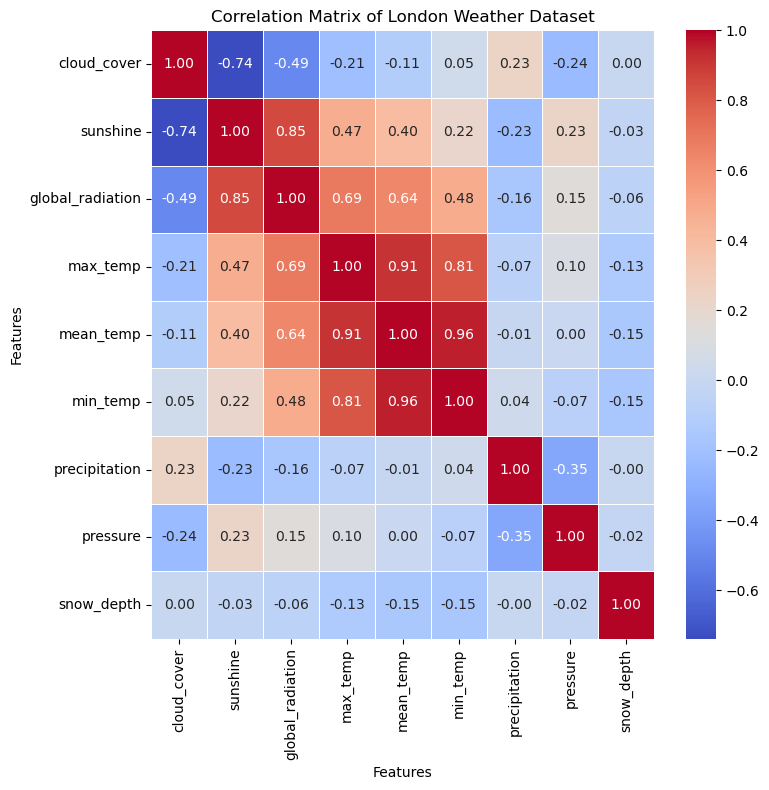

In [60]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 8))
seaborn.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of London Weather Dataset")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

##  Pregled pojedinih karakteristika 

Maksimalna, srednja i minimalna temperatura u poslednjih 10 godina

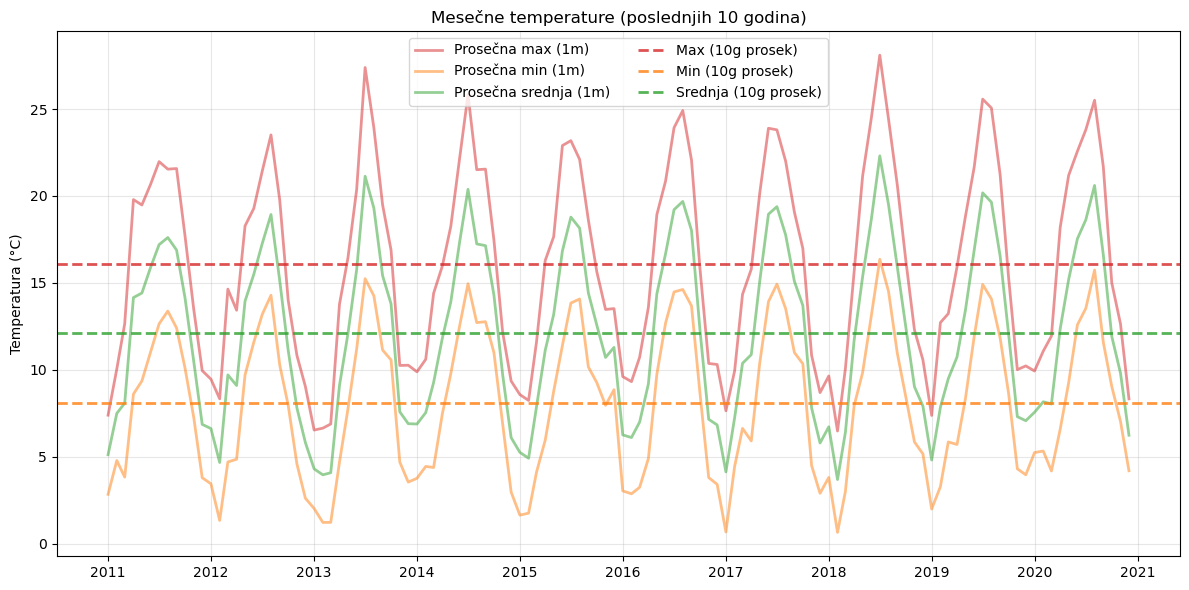

In [61]:
M = df[['max_temp', 'min_temp', 'mean_temp']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)
Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['max_temp'],  alpha=0.5, lw=2, label='Prosečna max (1m)', color='tab:red')
ax.plot(Mw.index, Mw['min_temp'],  alpha=0.5, lw=2, label='Prosečna min (1m)', color='tab:orange')
ax.plot(Mw.index, Mw['mean_temp'], alpha=0.5, lw=2, label='Prosečna srednja (1m)', color='tab:green')

ax.axhline(Mw['max_temp'].mean(),  color='tab:red',   ls='--', lw=2, alpha=0.8, label='Max (10g prosek)')
ax.axhline(Mw['min_temp'].mean(),  color='tab:orange',ls='--', lw=2, alpha=0.8, label='Min (10g prosek)')
ax.axhline(Mw['mean_temp'].mean(), color='tab:green', ls='--', lw=2, alpha=0.8, label='Srednja (10g prosek)')

ax.set_title('Mesečne temperature (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Temperatura (°C)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Pritisak

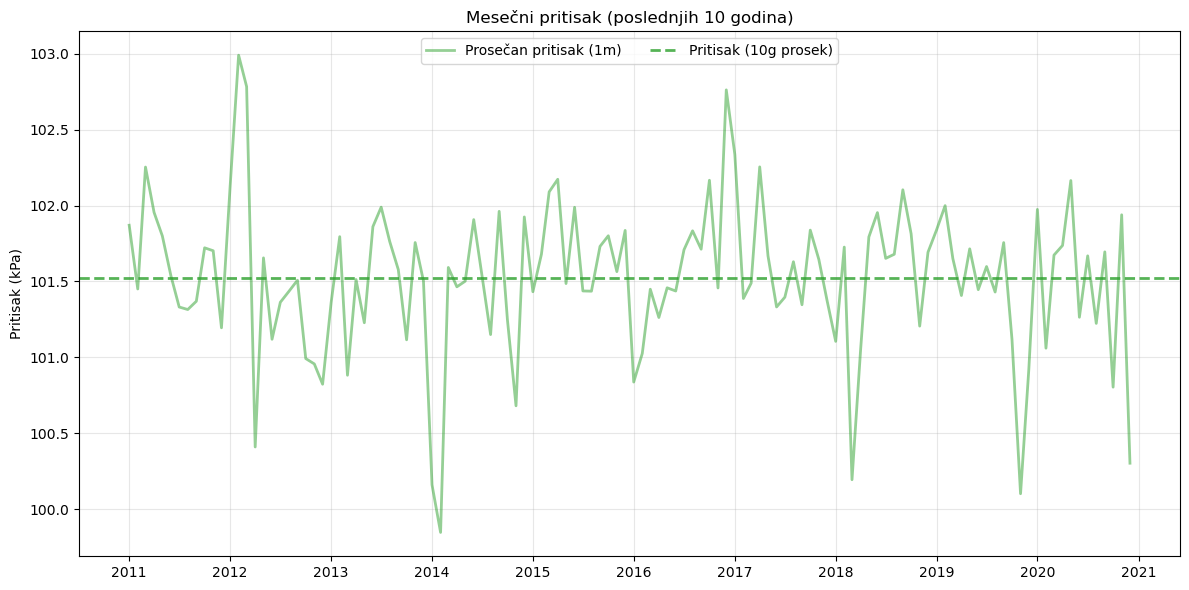

In [62]:
M = df[['pressure']].resample('MS').mean()/1000 # pretvaranje u kPa

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['pressure'],  alpha=0.5, lw=2, label='Prosečan pritisak (1m)', color='tab:green')

ax.axhline(Mw['pressure'].mean(),  color='tab:green',   ls='--', lw=2, alpha=0.8, label='Pritisak (10g prosek)')

ax.set_title('Mesečni pritisak (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Pritisak (kPa)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, loc='upper center')
plt.tight_layout()
plt.show()


Padavine

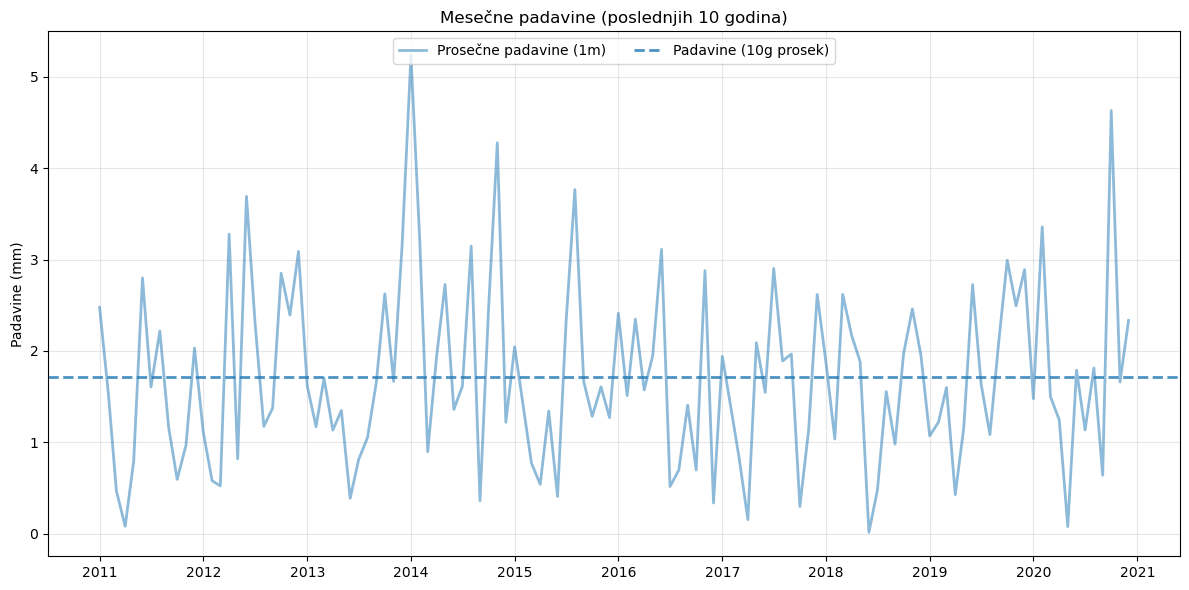

In [63]:
M = df[['precipitation']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['precipitation'],  alpha=0.5, lw=2,label='Prosečne padavine (1m)', color='tab:blue')

ax.axhline(Mw['precipitation'].mean(),  color='tab:blue',   ls='--', lw=2, alpha=0.8, label='Padavine (10g prosek)')

ax.set_title('Mesečne padavine (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Padavine (mm)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Snežni pokrivač

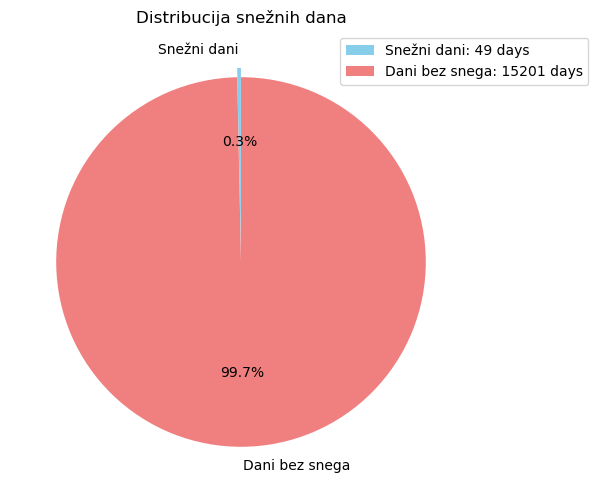

In [64]:
snow_counts = pd.Series({
    "Snežni dani": df['snow_depth'].where(lambda x: x>0).value_counts().values[0],
    "Dani bez snega": df['snow_depth'].where(lambda x: x==0).value_counts().values[0]
})

plt.figure(figsize=(6, 6))
snow_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=["skyblue", "lightcoral"],
    explode=(0.05, 0)
)
plt.title("Distribucija snežnih dana")
labels = [f"{cat}: {count} days" for cat, count in snow_counts.items()]
plt.legend(labels,bbox_to_anchor=(0.7, 1))
plt.show()

Radijacija Sunca

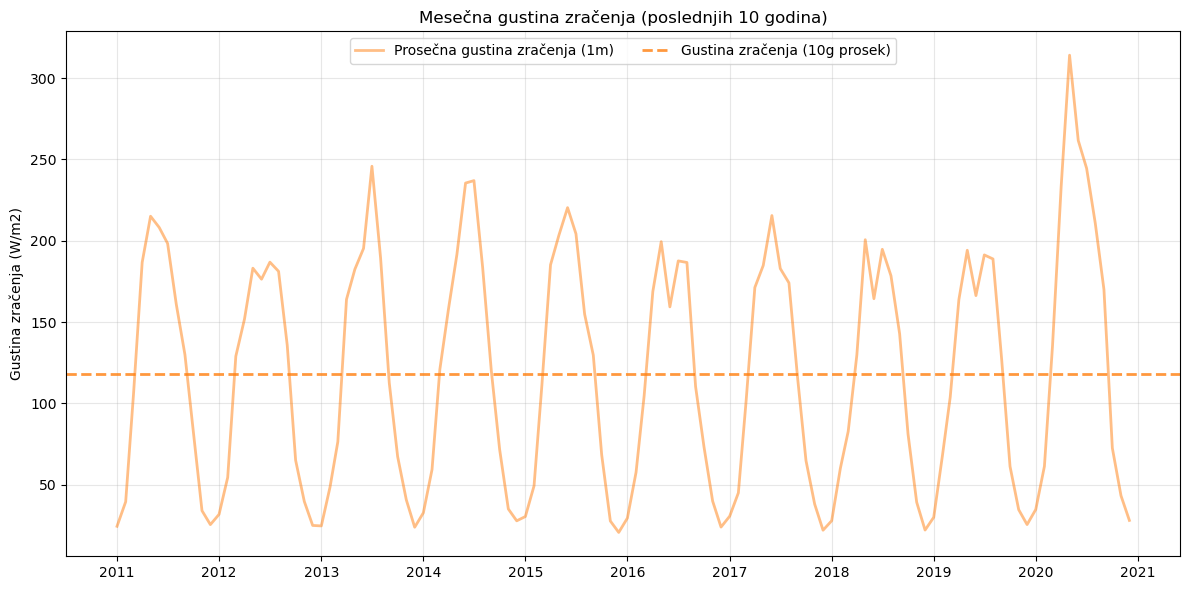

In [65]:
M = df[['global_radiation']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['global_radiation'],  alpha=0.5, lw=2,label='Prosečna gustina zračenja (1m)', color='tab:orange')

ax.axhline(Mw['global_radiation'].mean(),  color='tab:orange',   ls='--', lw=2, alpha=0.8, label='Gustina zračenja (10g prosek)')

ax.set_title('Mesečna gustina zračenja (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Gustina zračenja (W/m2)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Pokrivenost oblacima

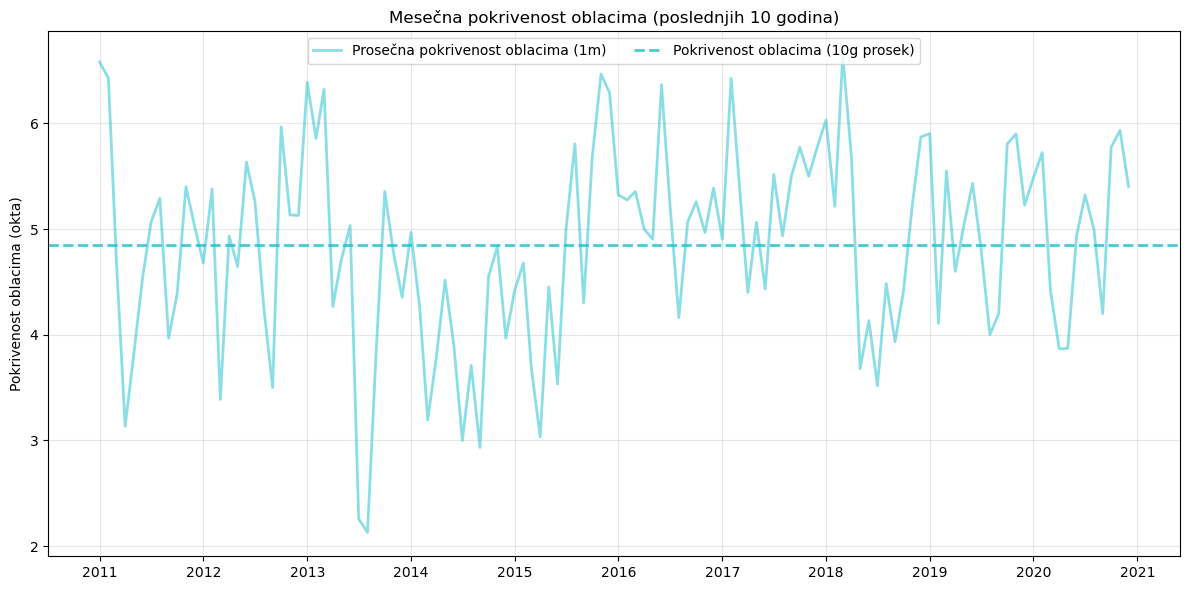

In [66]:
M = df[['cloud_cover']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['cloud_cover'],  alpha=0.5, lw=2,label='Prosečna pokrivenost oblacima (1m)', color='tab:cyan')

ax.axhline(Mw['cloud_cover'].mean(),  color='tab:cyan',   ls='--', lw=2, alpha=0.8, label='Pokrivenost oblacima (10g prosek)')

ax.set_title('Mesečna pokrivenost oblacima (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Pokrivenost oblacima (okta)') # okta: 0-8 skala za pokrivenost oblacima (0=bez oblaka, 8=potpuno oblačno)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Osunčanost

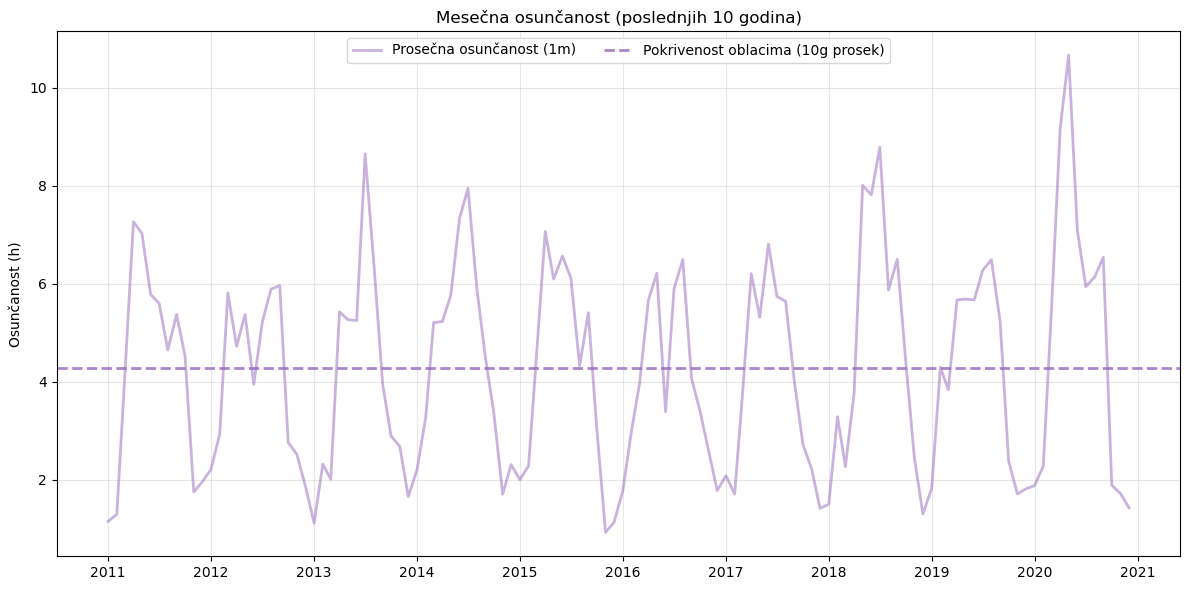

In [67]:
M = df[['sunshine']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['sunshine'],  alpha=0.5, lw=2,label='Prosečna osunčanost (1m)', color='tab:purple')

ax.axhline(Mw['sunshine'].mean(),  color='tab:purple',   ls='--', lw=2, alpha=0.8, label='Pokrivenost oblacima (10g prosek)')

ax.set_title('Mesečna osunčanost (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Osunčanost (h)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


In [68]:

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


def eval_metrics(model,y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)
    return pd.DataFrame([{
        "Model": model,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }])

# Linear regression

    Model      MAE      MSE    RMSE       R2
LinearReg 1.109394 2.062901 1.43628 0.675041
   Model      MAE      MSE     RMSE       R2
Naive-12 1.415846 3.227474 1.796517 0.491591


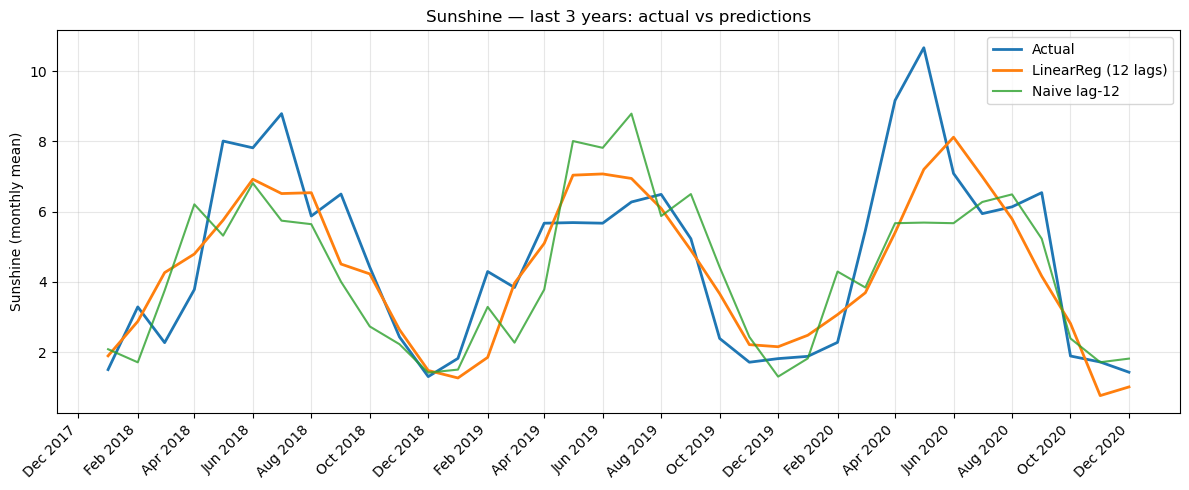

In [69]:
from sklearn.linear_model import LinearRegression

sun = df['sunshine'].resample('MS').mean()

def make_lags(series, lags=12):
    out = pd.DataFrame({'sunshine': series})
    for k in range(1, lags + 1):
        out[f'lag_{k}'] = series.shift(k)
    return out

data = make_lags(sun, lags=12).dropna()

test_start = pd.Timestamp('2018-01-01')
test_end   = df.index.max()

train = data.loc[data.index < test_start]
test  = data.loc[(data.index >= test_start) & (data.index <= test_end)]

X_train = train.drop(columns='sunshine').values
y_train = train['sunshine'].values
X_test  = test.drop(columns='sunshine').values
y_test  = test['sunshine'].values

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

y_naive = test['lag_12'].values

metrics_lr = eval_metrics("LinearReg",y_test, y_pred)
metrics_nv = eval_metrics("Naive-12",y_test, y_naive)

print(metrics_lr.to_string(index=False))
print(metrics_nv.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(test.index, y_test,  lw=2, label='Actual')
ax.plot(test.index, y_pred, lw=2, label='LinearReg (12 lags)')
ax.plot(test.index, y_naive, lw=1.5, alpha=0.8, label='Naive lag-12')

ax.set_title('Sunshine — last 3 years: actual vs predictions')
ax.set_ylabel('Sunshine (monthly mean)'); ax.set_xlabel('')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Testiranje modela

### Pomoćne funkcije

In [70]:
def make_windows(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback].values)
        ys.append(y.iloc[i+lookback])
    return np.array(Xs), np.array(ys)

In [71]:
scaller = MinMaxScaler()
df["day_of_year"] = df.index.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)
features = scaller.fit_transform(df.drop(columns=['sunshine']))
features = pd.DataFrame(features, columns=df.drop(columns=['sunshine']).columns)

target = df['sunshine']
features.index=df.index
target.index=df.index

In [72]:
def make_split(X,y,lookback):
    # Index for each window = end of window
    win_index = features.index[lookback:]  # DatetimeIndex length == len(X)

    # Choose boundaries
    train_end_date = pd.Timestamp("2015-01-01")
    val_end_date   = pd.Timestamp("2018-01-01")

    # Masks over windows
    train_mask = win_index <= train_end_date
    val_mask   = (win_index > train_end_date) & (win_index <= val_end_date)
    test_mask  = win_index > val_end_date

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]
    return X_train,y_train,X_val,y_val,X_test,y_test


def plot_loss(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_test(y_test,y_pred):
    idx = pd.date_range("2018-01-01", periods=1095, freq="D")
    df_pred = pd.DataFrame({
        "Actual": y_test,
        "LSTM": y_pred
    }, index=idx)

    df_monthly = df_pred.resample("MS").mean()

    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df_monthly.index, df_monthly["Actual"], lw=2, label="Actual (monthly mean)")
    ax.plot(df_monthly.index, df_monthly["LSTM"], lw=2, label="LSTM (monthly mean)")

    ax.set_title("Sunshine — last 3 years")
    ax.set_ylabel("Sunshine"); ax.set_xlabel("")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [73]:
X, y = make_windows(features, target, 30)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,30)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test {X_test.shape}, y_test: {y_test.shape}")


X_train: (13120, 30, 11), y_train: (13120,)
X_val: (1096, 30, 11), y_val: (1096,)
X_test (1095, 30, 11), y_test: (1095,)


## LSTM

In [74]:
# --- Windowing function ---
LOOKBACK = 7

X, y = make_windows(features, target, LOOKBACK)
print("X shape:", X.shape)  # (num_samples, lookback, num_features)
print("y shape:", y.shape)  # (num_samples,)

X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,LOOKBACK)
# --- Dataset pipeline ---
BATCH = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(128).batch(BATCH).prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(2)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(2)

# --- Build LSTM classifier ---
F = X.shape[-1]  # number of features
model = keras.Sequential([
    keras.layers.Input(shape=(LOOKBACK, F)),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(32,return_sequences=False),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1,activation="linear")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()

# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
    ]
)


X shape: (15334, 7, 11)
y shape: (15334,)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 64)             19456     
                                                                 
 dropout_15 (Dropout)        (None, 7, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 layer_normalization_9 (Laye  (None, 32)               64        
 rNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 32)                1056      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
            

5/5 [==============================] - 0s 5ms/step - loss: 8.2641 - root_mean_squared_error: 2.8747


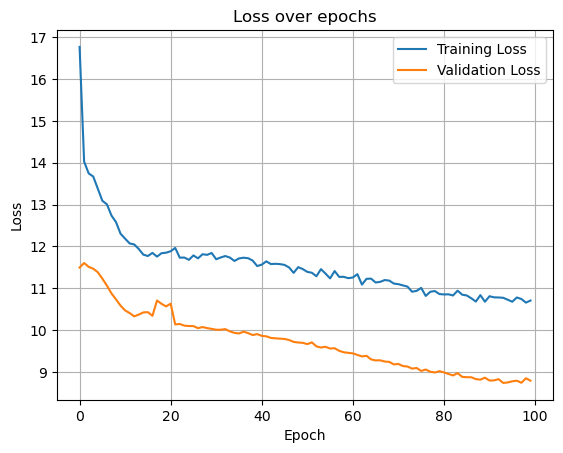

35/35 [==============================] - 1s 3ms/step


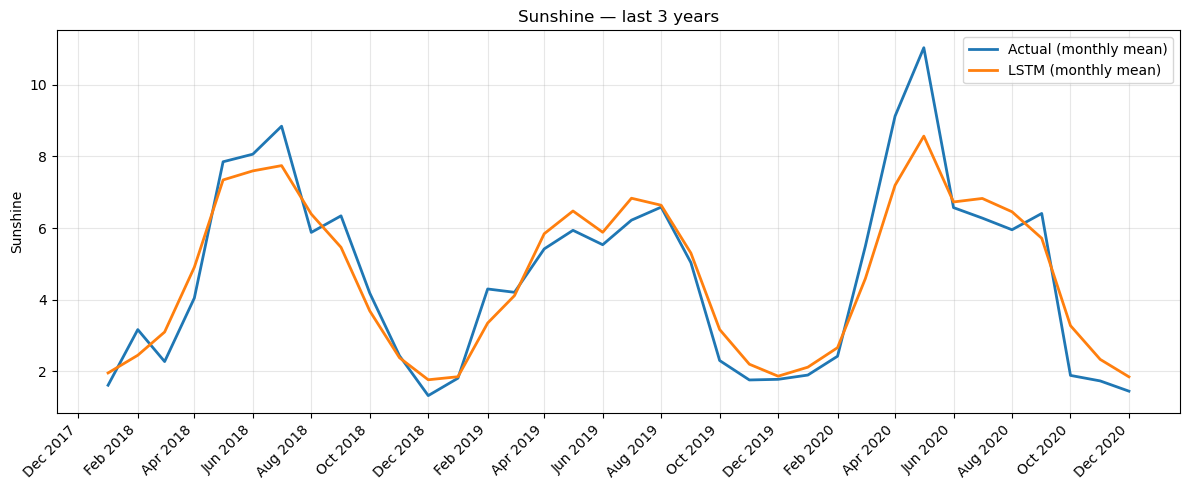

Model      MAE      MSE     RMSE       R2
 LSTM 2.394296 8.264122 2.874739 0.561164


In [75]:
test_loss, test_rmse = model.evaluate(test_ds)
plot_loss(history)
y_pred_lstm= model.predict(X_test).ravel()
plot_test(y_test,y_pred_lstm)
metrics_lstm = eval_metrics("LSTM",y_test, y_pred_lstm)
print(metrics_lstm.to_string(index=False))

## GRU

In [76]:
# --- Windowing function ---
LOOKBACK = 7  # past 7 days

X, y = make_windows(features, target, LOOKBACK)
print("X shape:", X.shape)  # (num_samples, lookback, num_features)
print("y shape:", y.shape)  # (num_samples,)

X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,LOOKBACK)

# --- Dataset pipeline ---
BATCH = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(128).batch(BATCH).prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(2)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(2)

# --- Build LSTM classifier ---
F = X.shape[-1]  # number of features
model = keras.Sequential([
    keras.layers.Input(shape=(LOOKBACK, F)),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.GRU(32,return_sequences=False),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1,activation="linear")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()

# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
    ]
)


X shape: (15334, 7, 11)
y shape: (15334,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 7, 64)             14784     
                                                                 
 dropout_17 (Dropout)        (None, 7, 64)             0         
                                                                 
 gru_10 (GRU)                (None, 32)                9408      
                                                                 
 layer_normalization_10 (Lay  (None, 32)               64        
 erNormalization)                                                
                                                                 
 dense_20 (Dense)            (None, 32)                1056      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
            

5/5 [==============================] - 0s 4ms/step - loss: 8.3714 - root_mean_squared_error: 2.8933


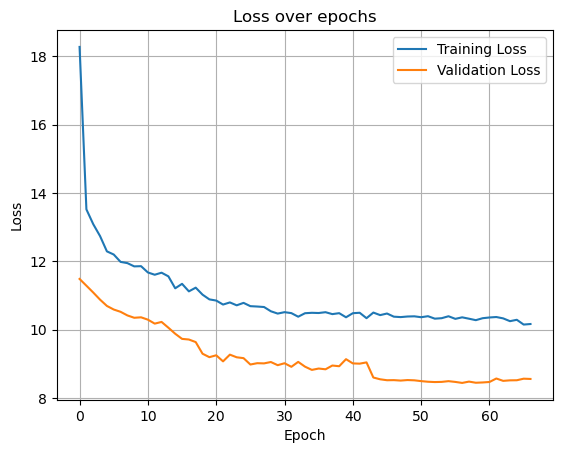

35/35 [==============================] - 1s 3ms/step


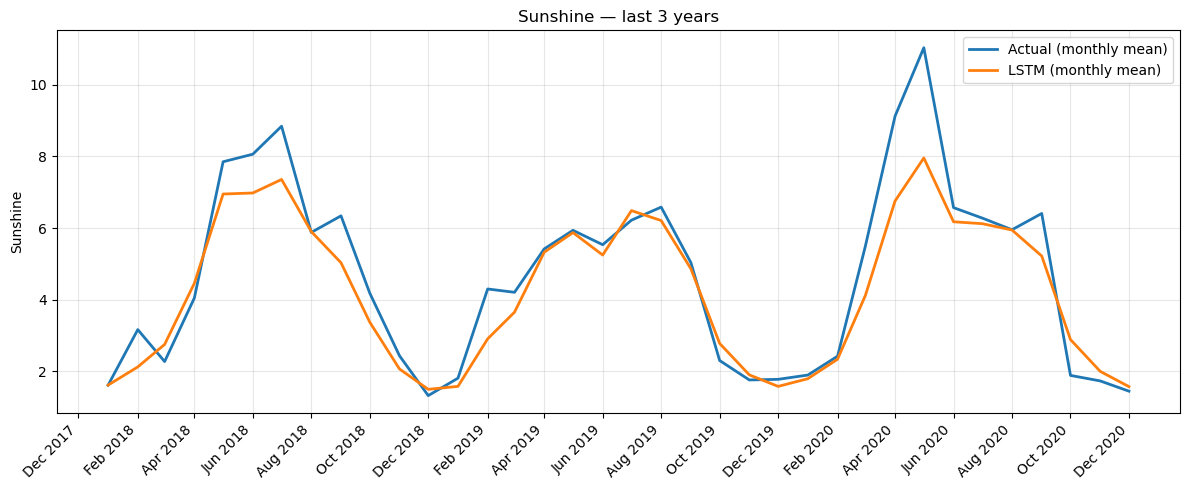

2.8933446407318115 8.371443748474121
Model      MAE      MSE     RMSE       R2
  GRU 2.350146 8.371443 2.893345 0.555465


In [77]:
test_loss, test_rmse = model.evaluate(test_ds)
plot_loss(history)
y_pred_gru = model.predict(X_test).ravel()
plot_test(y_test,y_pred_gru)
print(test_rmse,test_loss)
metrics_gru = eval_metrics("GRU",y_test, y_pred_gru)
print(metrics_gru.to_string(index=False))

## Testing some model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# ==== 1) Skaliraj TARGET (y) – RNN-u mnogo olakša ====
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(target.values.reshape(-1, 1)).ravel()

LOOKBACK = 7  # probaj {7, 14, 30}
X, y = make_windows(features, pd.Series(y_scaled, index=target.index), LOOKBACK)
print("X shape:", X.shape)  # (N, lookback, F)
print("y shape:", y.shape)

X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

# ==== 2) tf.data – cache + AUTOTUNE + manji batch ====
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64  # probaj i 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .cache()
    .shuffle(4096)
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .cache()
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(AUTOTUNE)

# ==== 3) Kompaktniji model – često bolji od dubokog stacka ====
F = X.shape[-1]

def build_model(cell="GRU", units=64, hidden=32, bidir=True, l2=1e-4, dropout=0.15, lr=3e-4):
    RNN = keras.layers.LSTM if cell.upper()=="LSTM" else keras.layers.GRU
    rnn = RNN(units, dropout=dropout, recurrent_dropout=0.0, return_sequences=False)
    if bidir:
        rnn = keras.layers.Bidirectional(rnn)

    inputs = keras.layers.Input(shape=(LOOKBACK, F))
    x = rnn(inputs)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Dense(hidden, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

# ➜ start sa GRU (češće pobedi na kraćim prozorima); probaj i cell="LSTM"
model = build_model(cell="GRU", units=64, hidden=32, bidir=False, l2=1e-4, dropout=0.15, lr=3e-4)
model.summary()

# ==== 4) Callbacks – mjeri šta ti je bitno i daj više vremena ====
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_rmse", patience=15, min_delta=1e-4,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5,
                                      patience=5, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=callbacks, verbose=1)


X shape: (15334, 7, 11)
y shape: (15334,)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 7, 11)]           0         
                                                                 
 gru_11 (GRU)                (None, 64)                14784     
                                                                 
 layer_normalization_11 (Lay  (None, 64)               128       
 erNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                 

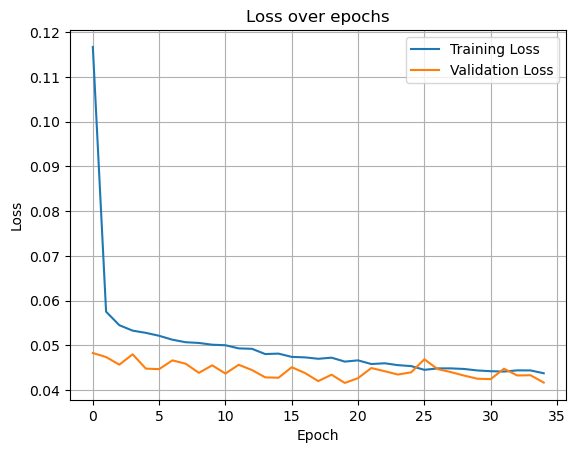

18/18 [==============================] - 0s 4ms/step


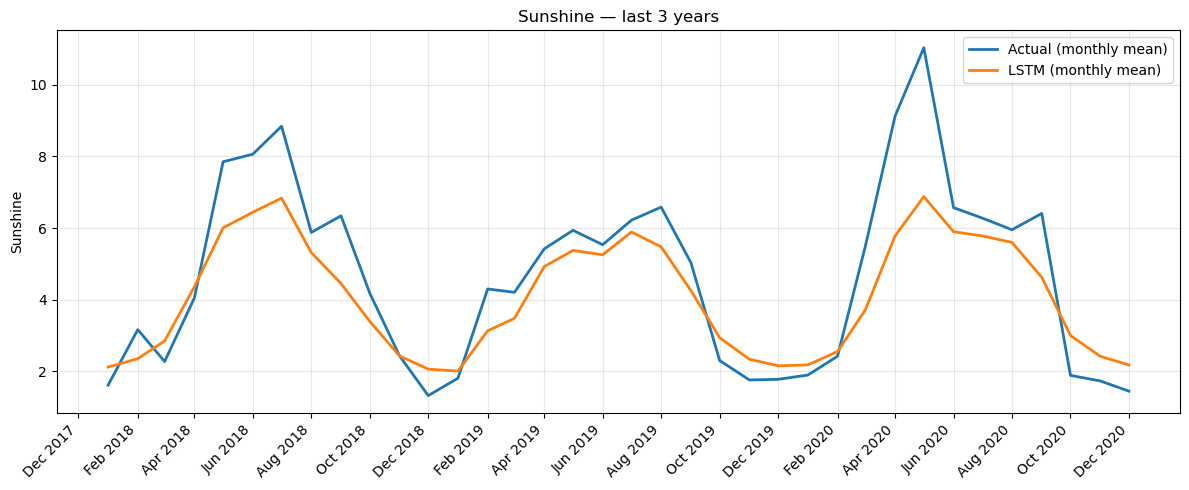

Model      MAE       MSE    RMSE       R2
  RNN 2.703194 10.947959 3.30877 0.418649


In [116]:
#test_loss, test_rmse = model.evaluate(test_ds)
plot_loss(history)
y_pred_scaled = model.predict(test_ds).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
plot_test(y_true,y_pred)
#print(test_rmse,test_loss)
metrics_rnn = eval_metrics("RNN",y_true, y_pred)
print(metrics_rnn.to_string(index=False))

## Overview of all models

In [121]:
results = pd.concat([
    metrics_lstm,
    metrics_gru,
    metrics_rnn
])
results

,Model,MAE,MSE,RMSE,R2
0,LSTM,2.394296,8.264122,2.874739,0.561164
0,GRU,2.350146,8.371443,2.893345,0.555465
0,RNN,2.703194,10.947959,3.308770,0.418649


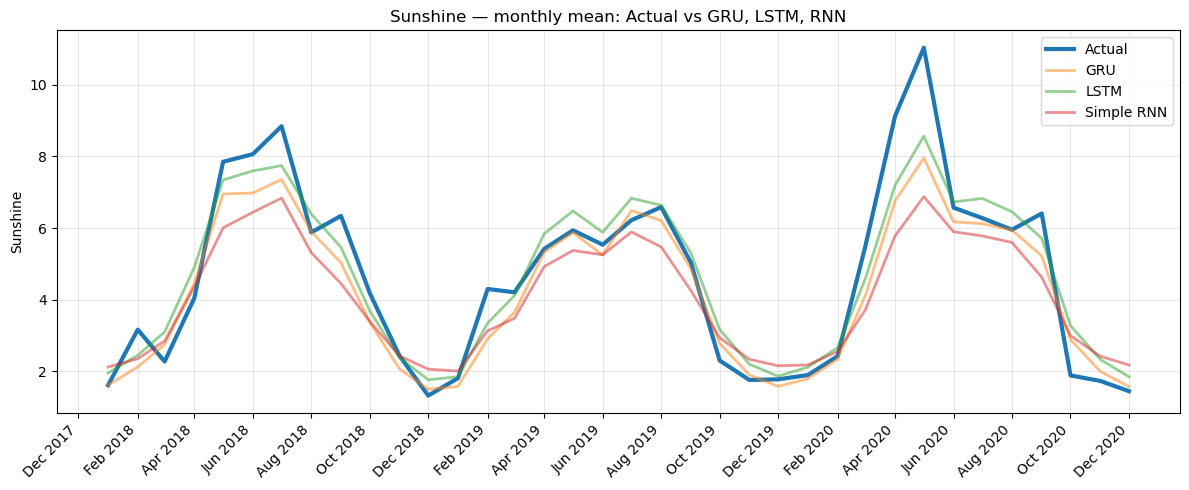

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_true,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm,
    "RNN": y_pred
}, index=idx)

# Mesečni prosek
df_monthly = df_models.resample("MS").mean()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_monthly.index, df_monthly["Actual"], lw=3, label="Actual")
ax.plot(df_monthly.index, df_monthly["GRU"], lw=2,alpha=0.5, label="GRU")
ax.plot(df_monthly.index, df_monthly["LSTM"], lw=2,alpha=0.5, label="LSTM")
ax.plot(df_monthly.index, df_monthly["RNN"], lw=2,alpha=0.5, label="Simple RNN")

ax.set_title("Sunshine — monthly mean: Actual vs GRU, LSTM, RNN")
ax.set_ylabel("Sunshine")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

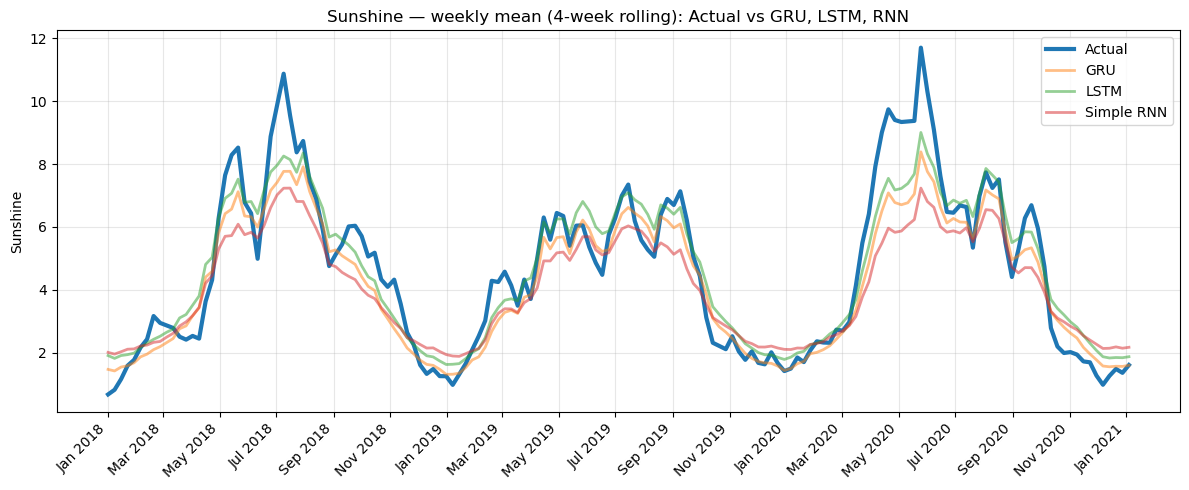

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_true,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm,
    "RNN": y_pred
}, index=idx)

# Mesečni prosek
df_weekly = df_models.resample("W-MON").mean()

df_weekly_roll = df_weekly.rolling(window=4, center=True, min_periods=2).mean()


fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_weekly_roll.index, df_weekly_roll["Actual"], lw=3, label="Actual")
ax.plot(df_weekly_roll.index, df_weekly_roll["GRU"], lw=2,alpha=0.5, label="GRU")
ax.plot(df_weekly_roll.index, df_weekly_roll["LSTM"], lw=2,alpha=0.5, label="LSTM")
ax.plot(df_weekly_roll.index, df_weekly_roll["RNN"], lw=2,alpha=0.5, label="Simple RNN")

ax.set_title("Sunshine — weekly mean (4-week rolling): Actual vs GRU, LSTM, RNN")
ax.set_ylabel("Sunshine")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

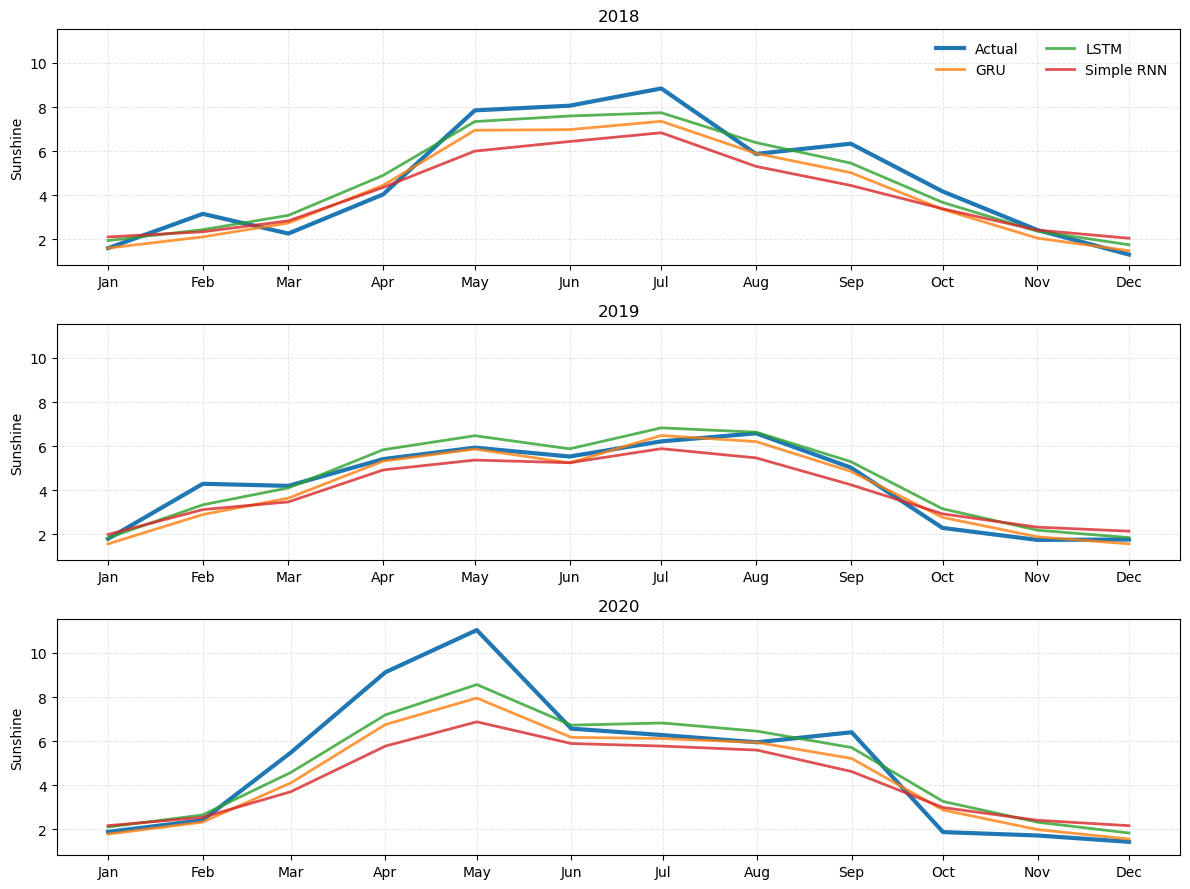

In [120]:
# 1) Monthly means
df_monthly = df_models.resample("MS").mean()

# 2) Last three years present (auto) — or set explicitly: years = [2018, 2019, 2020]
years = sorted(df_monthly.index.year.unique())[-3:]

import matplotlib.dates as mdates
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharey=True)

for ax, yr in zip(axes, years):
    m = df_monthly[df_monthly.index.year == yr]
    ax.plot(m.index, m["Actual"], lw=3, label="Actual")
    ax.plot(m.index, m["GRU"],   lw=2, alpha=0.8, label="GRU")
    ax.plot(m.index, m["LSTM"],  lw=2, alpha=0.8, label="LSTM")
    ax.plot(m.index, m["RNN"],   lw=2, alpha=0.8, label="Simple RNN")

    ax.set_title(f"{yr}")
    ax.set_ylabel("Sunshine")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)

# Legend once (top panel)
axes[0].legend(frameon=False, ncol=2)
axes[-1].set_xlabel("")  # no global xlabel
plt.tight_layout()
plt.show()
